# Entropy (synthetic)

Эксперименты с оценкой энтропии для синтетических данных.

# Преамбула

## Библиотеки

### Tensorflow

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

tfds.disable_progress_bar()
tf.enable_v2_behavior()

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices()

2.5.0
Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Math, Numpy, Scipy, Pandas

In [2]:
import math
import numpy as np
import scipy as sp
import scipy.stats as sps
import pandas as pd

### Matplotlib, Seaborn

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

### Sklearn

In [4]:
# Деревья.
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import BallTree
from sklearn.neighbors import KDTree

# Метрика.
from sklearn.metrics import pairwise_distances_argmin_min

# Метод главных компонент.
from sklearn.decomposition import PCA

# Выбор модели по кросс-валидации (поиск по сетке).
from sklearn.model_selection import GridSearchCV

### Joblib

In [5]:
from joblib import Parallel, delayed

n_jobs = 16

### Json, CSV, copy

In [6]:
import json
import csv
import copy

## Вспомогательное

In [7]:
# Информация об опыте.
info = dict()

In [8]:
def normalize_uint8(data, label):
    """Нормализация: `uint8` -> `float32`."""
    return tf.cast(data, tf.float32) / 255.0, label

In [9]:
def imshow_array(array):
    """Отображение массива нормированных пикселей."""
    plt.axis('off')
    plt.imshow((255.0 * array).astype(np.uint8), cmap=plt.get_cmap("gray"), vmin=0, vmax=255)

In [10]:
def dataset_Y_to_X(X, Y):
    """Поменять у датасета пары (X, Y) на (X, X) (нужно, например, для обучения автоэнкодера)."""
    return X, X

In [11]:
def concave_loss(y_true, y_pred):
    """Вогнутая функция потерь, дающая более четкие изображения при обучении."""
    delta = tf.keras.backend.abs(y_true - y_pred)
    squared = tf.keras.backend.square(y_true - y_pred)
    return tf.keras.backend.mean(delta - 0.5 * squared, axis=-1)

## Google Drive

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

In [13]:
#path = "/content/drive/My Drive/Information_v2/"
path = "/tf/home/sirius/Projects/Information-v2/data/"

# Синтетические данные

Для первоначальных экспериментов данные синтезируются путем сэмплирования точек из некоторого распределения с последующим отображением на некоторое многообразие.

In [14]:
dataset_dim = 8  # Размерность данных.
latent_dim  = 2  # Реальная (скрытая) размерность данных.
final_noize_stdev = 0.05 # Стандартное отклонение шума, складываемого с выходом функции.
samples_number = 600000 # Размер выборки.
tests_number   = 10000 # Размер тестовой выборки.

In [15]:
experiments_path = path + "synthetic/"

### Распределения

In [16]:
class rv_multidim:
    """Базовый класс для многомерных распределений (структура взята из scipy.stats.rv_continuous)"""

    def __init__(self, momtype=1, xtol=1e-14, badvalue=None, name=None, longname=None, shapes=None, extradoc=None, seed=None):
        if badvalue is None:
            self.badvalue = np.nan
        else:
            self.badvalue = badvalue

        self.name = name
        self.longname = longname
        self.shapes = shapes
        self.extradoc = extradoc
        self.seed = seed

    def rvs(self, *args, **kwds):
        """Сэмплирование."""
        return self._rvs(*args, **kwds)

    def pdf(self, x, *args, **kwds):
        """Функция плотности."""
        return self._pdf(x, *args, **kwds)
    
    def logpdf(self, x, *args, **kwds):
        """Логарифм функции плотности."""
        return np.log(self.pdf(x, *args, **kwds))

    def cdf(self, x, *args, **kwds):
        """Функция распределения."""
        return 1.0 - self.pdf(x, *args, **kwds)

    def logcdf(self, x, *args, **kwds):
        """Логарифм функции распределения."""
        return np.log(self.cdf(x, *args, **kwds))

    def entropy(self, *args, **kwds):
        """Энтропия."""
        return self._entropy(*args, **kwds)

In [17]:
# переделанный класс для строк: поддерживает работу с несколькими массивами

class some_hor_stripes(rv_multidim):
    """Несколько полос с равномерным распределением."""

    def __init__(self, loc_x=np.array([-5, -1, 3]), scale_x=np.array([1, 1, 1]), loc_y=-np.pi, scale_y=2.0*np.pi, seed=None):
        super(some_hor_stripes, self).__init__(name="some distributed stripes", 
                                               longname="some distributed stripes",
                                               shapes="loc_x, scale_x", seed=seed)

        assert len(ranks) != 0, 'Список ranks не должен быть пустым'


        self._loc_x = loc_x
        self._scale_x = scale_x
        self._loc_y = loc_y
        self._scale_y = scale_y


    def _rvs(self, size=1, random_state=None):

        number = sps.randint(low=0, high=3).rvs(1, random_state=None)
        return np.vstack((sps.uniform(loc=self._loc_x[number], scale=self._scale_x[number]).rvs(size, random_state=random_state), 
                         sps.uniform(loc=self._loc_y, scale=self._scale_y).rvs(size, random_state=random_state))).T

    def _entropy(self):
        return np.log(self._loc_x.sum() * self._scale_y)

In [18]:
class three_uniform_stripes(rv_multidim):
    """Три полосы с равномерным распределением."""

    def __init__(self, loc_x=-np.pi, scale_x=2.0*np.pi, loc_y1=-5, scale_y1=2, loc_y2=-1, scale_y2=2, loc_y3=3, scale_y3=2, seed=None):
        super(three_uniform_stripes, self).__init__(name="Three uniformly distributed stripes", longname="Three uniformly distributed stripes",
                                                    shapes="loc_x1, scale_x1, loc_x2, scale_x2, loc_x3, scale_x3", seed=seed)
        
        self._loc_x    = loc_x
        self._scale_x  = scale_x
        self._loc_y1   = loc_y1
        self._scale_y1 = scale_y1
        self._loc_y2   = loc_y2
        self._scale_y2 = scale_y2
        self._loc_y3   = loc_y3
        self._scale_y3 = scale_y3

        self._stripe_x  = sps.uniform(self._loc_x,  self._scale_x)
        self._stripe_y1 = sps.uniform(self._loc_y1, self._scale_y1)
        self._stripe_y2 = sps.uniform(self._loc_y2, self._scale_y2)
        self._stripe_y3 = sps.uniform(self._loc_y3, self._scale_y3)

    def _rvs(self, size=1, random_state=None):
        X1 = self._stripe_x.rvs(size, random_state)
        
        X01 = self._stripe_y1.rvs(size, random_state)
        X02 = self._stripe_y2.rvs(size, random_state)
        X03 = self._stripe_y3.rvs(size, random_state)

        X0 = np.concatenate((X01, X02, X03), axis = None)
        X2 = np.random.choice(X0, size = size, replace = False)

        X = np.column_stack((X1,X2))

        return X

    def _entropy(self):
        return np.log((self._scale_y1 + self._scale_y2 + self._scale_y3) * self._scale_x)

In [19]:
class One_Ring(rv_multidim):
    """Кольцо, полученное из прямоугольника с равномерным распределением."""

    def __init__(self, loc_x=-np.pi, scale_x=2.0*np.pi, less_rad = 1, bigg_rad = 2, seed=None):
        super(One_Ring, self).__init__(name="One Ring that rules them all", longname="One Ring that rules them all",
                                                    shapes="loc_x, scale_x, less_rad, bigg_rad", seed=seed)
        
        assert ((loc_x >= -np.pi) and (scale_x <= 2.0 * np.pi) and (less_rad > 0) and (bigg_rad > less_rad))

        self._loc_x    = loc_x
        self._scale_x  = scale_x
        self._loc_y   = less_rad
        self._scale_y = bigg_rad - less_rad

        self._uniform_x = sps.uniform(self._loc_x, self._scale_x)
        self._uniform_y = sps.uniform(self._loc_y, self._scale_y)

    def _rvs(self, size=1, random_state=None):
        X01 = self._uniform_x.rvs(size, random_state)        
        X02 = self._uniform_y.rvs(size, random_state)

        #X1 = np.zeros(size)
        #X2 = np.zeros(size)

        #for i in range (0,size-1):
        #    X1[i] = X02[i] * np.cos(X01[i])
        #    X2[i] = X02[i] * np.sin[X01[i]]
        
        X1 = X02 * np.cos(X01)
        X2 = X02 * np.sin(X01)

        X = np.column_stack((X1,X2))

        return X

    def _entropy(self):
        return ((self._loc_y + self._scale_y) * (np.log((self._loc_y + self._scale_y) * self._scale_x) - 1) -
                self._loc_y * (np.log(self._loc_y * self._scale_x) - 1))

In [20]:
class rv_composite(rv_multidim):
    """ Многомерное распределение, независимое по каждой координате."""

    def __init__(self, rv_list):
        self.rv_list = rv_list

    def _rvs(self, size=1, random_state=None):
        XI = []
        
        for i in range(0, len(self.rv_list)):
            XI.append(self.rv_list[i].rvs(size, random_state))
            X = np.column_stack(XI)
        return X

    def _entropy(self):
        entr = 0.0
        
        for i in range(0, len(self.rv_list)):
            entr += self.rv_list[i].entropy()
            
        return entr

### Отображения

In [21]:
class mapping_smooth:
    """Базовый класс для кусочно гладких отображений"""

    def __init__(self):
        self.input_dim  = None
        self.output_dim = None

    def map(self, x):
        """Отобразить x."""
        return self._map(x)

    def jac(self, x):
        """Матрица Якоби."""
        return self._jac(x)

    def defc(self, x):
        """Коэффициент растяжения."""
        return self._defc(x)

#### Полуцилиндр

$$
(x',y',z') = g_1(x,y): \quad \begin{matrix} x' = \begin{cases}
\sin(x), \; x \in \left[-\frac{\pi}{2}, \frac{\pi}{2}\right] \\
sign(x), \; else
\end{cases} \\
y' = y \\
z' = \begin{cases}
\cos(x), \; x \in \left[-\frac{\pi}{2}, \frac{\pi}{2}\right] \\
-\left| x - sign(x) \frac{\pi}{2} \right|, \; else
\end{cases}
\end{matrix}
$$

In [22]:
class Semicylinder(mapping_smooth):
    """
    Функция 1, задающая отображение плоскости на бесконечный цилиндр с основанием "полукруг + два параллельных луча".
    """

    def __init__(self):
        self.input_dim  = 2
        self.output_dim = 3

    def _map(self, x):
        y = np.zeros(3)

        if ((x[0] >= - np.pi / 2) and (x[0] <= np.pi / 2)):
            y[0] = np.sin(x[0])
            y[1] = x[1]
            y[2] = np.cos(x[0])
        else:
            y[0] = np.sign(x[0])
            y[1] = x[1]
            y[2] = -np.abs(x[0] - (np.sign(x[0]) * np.pi / 2))

        return y

    def _jac(self, x):
        if ((x[0] >= -np.pi / 2) and (x[0] <= np.pi/2)):
            return np.array([[np.cos(x[0]), 0.0, -np.sin(x[0])],
                             [0.0, 1.0, 0.0]])
        else:
            return np.array([[np.cos(x[0]), 0.0, -np.sin(x[0])],
                             [0.0, 1.0, 0.0]])
        
    def _defc(self, x):
        return 1.0

#### Бинокль

$$
(x',y',z') = g_2(x,y): \quad \begin{matrix} x' = sign(x)\left(1-\cos(x)\right)\\
y' = y \\
z' = -\sin(x)
\end{matrix}
$$

In [23]:
class Bicylinder(mapping_smooth):
    """
    Функция 2, задающая отображение полосы (-2pi, 2pi) x \RR на "двойную трубку".
    """

    def __init__(self):
        self.input_dim  = 2
        self.output_dim = 3

    def _map(self, x):
        assert ((x[0] >= -2.0 * np.pi) and (x[0] <= 2.0 * np.pi))

        y = np.zeros(3)
        
        y[0] = np.sign(x[0]) * (1 - np.cos(x[0]))
        y[1] = x[1]
        y[2] = - np.sin(x[0])

        return y

    def _jac(self, x):
        assert ((x[0] >= -2.0 * np.pi) and (x[0] <= 2.0 * np.pi))

        return np.array([[np.sin(x[0]) * np.sign(x[0]), 0.0, -np.cos(x[0])],
                         [0.0, 1.0, 0.0]])
        
    def _defc(self, x):
        assert ((x[0] >= -2.0 * np.pi) and (x[0] <= 2.0 * np.pi))

        return 1.0

#### Сфера ("обратная" проекция Меркатора)

$$
(x',y',z') = g_3(x,y): \quad \begin{matrix} 
x' = \cos x \cos\left(\arctan\left((\sinh y\right)\right) \\
y' = \sin x \cos\left(\arctan\left((\sinh y\right)\right) \\
z' = \sin\left(\arctan\left((\sinh y\right)\right)
\end{matrix}
$$

In [24]:
class inverse_Mercator(mapping_smooth):
    """
    Функция 3, задающая отображение полосы (-pi, pi] x \RR на сферу единичного радиуса.
    """

    def __init__(self):
        self.input_dim  = 2
        self.output_dim = 3

    def _map(self, x):
        assert ((x[0] >= -np.pi) and (x[0] <= np.pi))
        
        y = np.zeros(3)
        
        y[0] = np.cos(x[0]) * np.cos(np.arctan(np.sinh(x[1])))
        y[1] = np.sin(x[0]) * np.cos(np.arctan(np.sinh(x[1])))
        y[2] = np.sin(np.arctan(np.sinh(x[1])))

        return y

    def _jac(self, x):
        assert ((x[0] >= -np.pi) and (x[0] <= np.pi))

        return np.array([[-np.sin(x[0]) * np.cos(np.arctan(np.sinh(x[1]))), np.cos(x[0]) * np.cos(np.arctan(np.sinh(x[1]))), 0.0],
                         [-np.sinh(x[1]) * np.cosh(x[1]) * np.cos(x[0]) / np.power((np.power(np.sinh(x[1]), 2) + 1),(3 / 2)), -np.sinh(x[1]) * np.cosh(x[1]) * np.sin(x[0]) / np.power((np.power(np.sinh(x[1]), 2) + 1),(3 / 2)), -np.cosh(x[1]) / np.power((np.power(np.sinh(x[1]), 2) + 1),(3 / 2))]])
        
    def _defc(self, x):
        assert ((x[0] >= -np.pi) and (x[0] <= np.pi))
        
        return np.cos(np.arctan(np.sinh(x[1]))) / np.cosh(x[1])

#### "Плохой" (п.в. дифференцируемый) полуцилиндр

$$
(x',y',z') = g_4(x,y): \quad \begin{matrix} x' = \begin{cases}
\sin(x), \; x \in \left[-\frac{\pi}{2}, \frac{\pi}{2}\right] \\
sign(x) \left(\left|x\right|-\frac{\pi}{2}+1\right), \; else
\end{cases} \\
y' = y \\
z' = \begin{cases}
\cos(x), \; x \in \left[-\frac{\pi}{2}, \frac{\pi}{2}\right] \\
0, \; else
\end{cases}
\end{matrix}
$$

In [25]:
class BadSemicylinder(mapping_smooth):
    """
    Функция 4, задающая отображение плоскости на бесконечный цилиндр с основанием "полукруг + два луча в стороны".
    """

    def __init__(self):
        self.input_dim  = 2
        self.output_dim = 3

    def _map(self, x):
        y = np.zeros(3)

        if ((x[0] >= - np.pi / 2) and (x[0] <= np.pi / 2)):
            y[0] = np.sin(x[0])
            y[1] = x[1]
            y[2] = np.cos(x[0])
        else:
            y[0] = np.sign(x[0]) * (np.abs(x[0]) - (np.pi / 2) + 1)
            y[1] = x[1]
            y[2] = 0

        return y

    def _jac(self, x):
        if ((x[0] >= -np.pi / 2) and (x[0] <= np.pi/2)):
            return np.array([[np.cos(x[0]), 0.0, -np.sin(x[0])],
                             [0.0, 1.0, 0.0]])
        else:
            return np.array([[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0]])

    def _defc(self, x):
        return 1.0

#### Композитное многомерное преобразование

In [26]:
class mapping_composite(mapping_smooth):
    """
    Функция 5, задающая отображение n-мерного многообразия на 3*[n/2] + n-2*[n/2]-мерное.
    """

    def __init__(self, mappings_list):
        self.input_dim = 0
        self.output_dim = 0
        for i in range(0, len(mappings_list)):
            self.input_dim += mappings_list[i].input_dim
            self.output_dim += mappings_list[i].output_dim
        self.mappings_list = mappings_list

    def _map(self, x):
        y = np.zeros(self.output_dim)

        taken_x = 0
        taken_y = 0
        
        for i in range(0, len(self.mappings_list)):
            y[taken_y:taken_y + self.mappings_list[i].output_dim] = self.mappings_list[i].map(x[taken_x:taken_x + self.mappings_list[i].input_dim])
            
            taken_x += self.mappings_list[i].input_dim
            taken_y += self.mappings_list[i].output_dim
            
        return y

    def _jac(self, x):
        jacs = []
        
        taken_x = 0
        
        for i in range(0, len(self.mappings_list)):    
            jacs.append(self.mappings_list[i].jac(np.array(x[taken_x:taken_x + self.mappings_list[i].input_dim])))
            taken_x += self.mappings_list[i].input_dim        
                
        return spl.block_diag(*jacs)

    def _defc(self, x):
        defcs = []
        
        taken_x = 0
        
        for i in range(0, len(self.mappings_list)):            
            defcs.append(self.mappings_list[i].defc(x[taken_x:taken_x + self.mappings_list[i].input_dim]))
            taken_x += self.mappings_list[i].input_dim        
              
        defc = 1.0
        
        for i in range(0, len(defcs)):
            defc *= defcs[i]
            
        return defc

### Выбор случайной величины и отображения

In [27]:
random_variables = [three_uniform_stripes(),
                    One_Ring(less_rad = 4.0, bigg_rad = 6.0),
                    rv_composite([sps.uniform(-np.pi, 2.0 * np.pi), sps.norm()]),
                    rv_composite([sps.semicircular(-np.pi, 2.0 * np.pi), sps.norm()])]
mappings = [Semicylinder(), Bicylinder(), inverse_Mercator(), BadSemicylinder()]

In [28]:
# НОМЕР ИСХОДНОГО РАСПРЕДЕЛЕНИЯ.
# #
# #
random_variable_index = 2
# #
# #

In [29]:
# НОМЕР ФУНКЦИИ, ЗАДАЮЩЕЙ МНОГООБРАЗИЕ.
# #
# #
mapping_index = 2
# #
# #

In [30]:
random_variable = random_variables[random_variable_index - 1]
mapping = mappings[mapping_index - 1]

# Проверка входной размерности.
assert latent_dim == mapping.input_dim

true_entropy = random_variable.entropy()

### Генерация набора данных

In [31]:
# Матрица поворота и повышения размерности.
Q = sps.ortho_group.rvs(dim = dataset_dim)
#Q = np.eye(dataset_dim)
transform = Q[:,:mapping.output_dim]

#print(transform)

In [32]:
def get_samples(random_variable, mapping, samples_number, dataset_dim, transform_matrix, final_noize_stdev = 0.05):
    """
    Генерация набора данных.
    """

    # Данные во внутреннем представлении.
    #np.random.seed(42)
    X = random_variable.rvs(samples_number)
    
    # Отображение шума в пространство большей размерности.
    Y = np.zeros((samples_number, dataset_dim))
    noize = sps.norm(loc=0, scale=final_noize_stdev)
    for i in range(samples_number):
        Y[i] = transform_matrix @ mapping.map(X[i]) + noize.rvs(dataset_dim)
            
    return Y

In [33]:
samples = get_samples(random_variable, mapping, samples_number, dataset_dim, transform, final_noize_stdev)
tests   = get_samples(random_variable, mapping, tests_number,   dataset_dim, transform, final_noize_stdev)

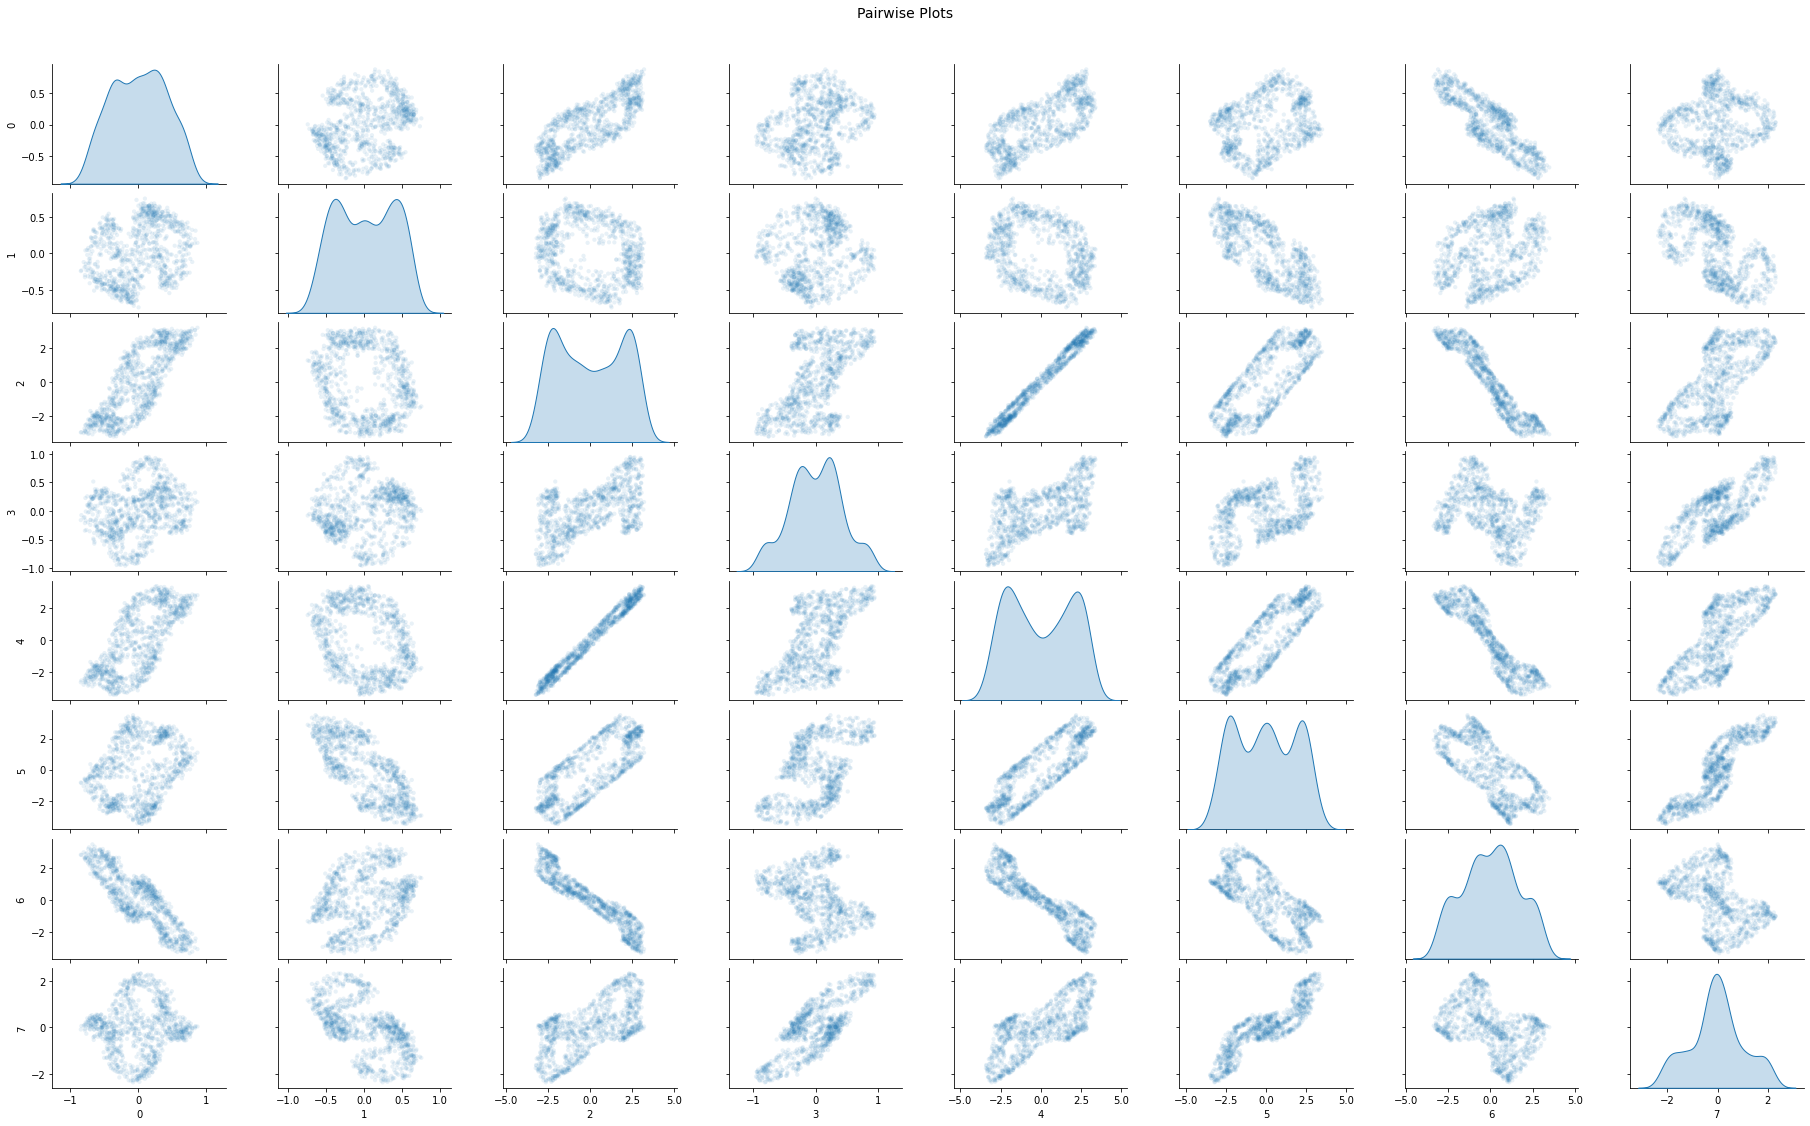

In [34]:
draw_pair_plot = True
if draw_pair_plot:
    pp = sns.pairplot(pd.DataFrame(samples[:1000]), height = 2.0, aspect=1.6,
                      plot_kws=dict(edgecolor="k", linewidth=0.0, alpha=0.1, size=0.01, s=0.01),
                      diag_kind="kde", diag_kws=dict(shade=True))

    fig = pp.fig
    fig.subplots_adjust(top=0.93, wspace=0.3)
    t = fig.suptitle('Pairwise Plots', fontsize=14)

### Путь к результатам

In [35]:
dataset_path = experiments_path + "rv_" + str(random_variable_index) + "_map_" + str(mapping_index) + "/" + str(latent_dim) + "_" + str(dataset_dim) + '/' + ("%.3e" % final_noize_stdev) + "/" + str(samples_number) + "_" + str(tests_number) + "/"

# Оценка энтропии

## Автокодировщик

Сжатие данных предлагается делать автокодировщиком.
Для архитектуры специфицируется только формат входных данных, а также размерность внутреннего представления (кодов).

In [36]:
# РАЗМЕРНОСТЬ КОДА.
# #
# #
 
codes_dim = 2

# #
# #

In [37]:
# Число эпох для обучения.
epochs = 100

In [38]:
import os
full_path = dataset_path + "autoencoders/" + str(codes_dim) + "_" + str(epochs) + "/"
os.makedirs(full_path, exist_ok=True)

In [39]:
info['dataset_dim'] = dataset_dim
info['latent_dim'] = latent_dim

info['samples_number'] = samples_number
info['tests_number'] = tests_number

info['codes_dim'] = codes_dim
info['epochs'] = epochs

### Создание модели

In [40]:
def dense_autoencoder(shape_input, dimension):
    # Инициализация весов.
    init = tf.keras.initializers.RandomNormal(stddev = 0.02)

    # Входные данные генератора / выборки.
    input_layer = tf.keras.layers.Input(shape_input)
    next_layer = input_layer
    next_layer = tf.keras.layers.GaussianNoise(0.05)(next_layer)

    # 1 блок слоёв.
    next_layer = tf.keras.layers.Dense(32, kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)

    # 2 блок слоёв.
    next_layer = tf.keras.layers.Dense(16, kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # 3 блок слоёв.
    #next_layer = tf.keras.layers.Dense(8, kernel_initializer = init)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # 4 блок слоёв.
    #next_layer = tf.keras.layers.Dense(4, kernel_initializer = init)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)

    # Бутылочное горлышко.
    next_layer = tf.keras.layers.Dense(dimension)(next_layer)
    bottleneck = tf.keras.layers.Activation('tanh')(next_layer)

    # Модель кодировщика.
    encoder = tf.keras.Model(input_layer, bottleneck)

    # Начало модели декодировщика.
    input_code_layer = tf.keras.layers.Input((dimension))
    next_layer = input_code_layer
    
    # 4 блок слоёв.
    #next_layer = tf.keras.layers.Dense(4, kernel_initializer = init)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)

    # 3 блок слоёв.
    #next_layer = tf.keras.layers.Dense(8, kernel_initializer = init)(next_layer)
    #next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # 2 блок слоёв.
    next_layer = tf.keras.layers.Dense(16, kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)

    # 1 блок слоёв.
    next_layer = tf.keras.layers.Dense(32, kernel_initializer = init)(next_layer)
    next_layer = tf.keras.layers.LeakyReLU(alpha=0.2)(next_layer)
    
    # 0 блок слоёв.
    next_layer = tf.keras.layers.Dense(shape_input[0])(next_layer) # Подразумевается, что вход - всё равно вектор.
    #next_layer = tf.keras.layers.Activation('tanh')(next_layer)
    
    output_layer = next_layer

    
    # Модель.
    decoder = tf.keras.models.Model(input_code_layer, output_layer) # Декодировщик.
    autoencoder = tf.keras.Sequential([encoder, decoder])

    # Компиляция модели.
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    autoencoder.compile(loss = 'mse', optimizer = opt, loss_weights = [1.0])
    
    return encoder, decoder, autoencoder

### Загрузка модели

In [41]:
#encoder = tf.keras.models.load_model(full_path + "encoder.h5")
#decoder = tf.keras.models.load_model(full_path + "decoder.h5")
#autoencoder = autoencoder = tf.keras.Sequential([encoder, decoder])
#autoencoder.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), loss_weights = [1.0])

#with open(full_path + 'info.json', 'r') as fp:
#    info = json.load(fp)

In [42]:
encoder, decoder, autoencoder = dense_autoencoder((dataset_dim,), codes_dim)

In [ ]:
history_callback = autoencoder.fit(samples, samples, epochs=epochs, validation_data=(tests, tests), batch_size=128)

Epoch 1/100
4688/4688 [==============================] - 13s 3ms/step - loss: 0.1956 - val_loss: 0.0198
Epoch 2/100
4688/4688 [==============================] - 13s 3ms/step - loss: 0.0159 - val_loss: 0.0131
Epoch 3/100
4688/4688 [==============================] - 12s 3ms/step - loss: 0.0125 - val_loss: 0.0112
Epoch 4/100
4688/4688 [==============================] - 13s 3ms/step - loss: 0.0106 - val_loss: 0.0091
Epoch 5/100
4688/4688 [==============================] - 12s 3ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 6/100
4688/4688 [==============================] - 12s 3ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 7/100
4688/4688 [==============================] - 13s 3ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 8/100
4688/4688 [==============================] - 13s 3ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 9/100
4688/4688 [==============================] - 11s 2ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 10/100
4688/4688 [==============================] - 12s 3m

In [ ]:
# Сохранение динамики loss-функции.
loss_history = np.array(history_callback.history["loss"])
val_loss_history = np.array(history_callback.history["val_loss"])

np.savetxt(full_path + "loss.csv", loss_history, delimiter="\n")
np.savetxt(full_path + "val_loss.csv", val_loss_history, delimiter="\n")

In [ ]:
# Сохранение средних итоговых значений функции потерь.
last_n = 20
last_loss = np.array(loss_history[-last_n:])
last_loss_mean = np.mean(last_loss)
last_loss_std = np.std(last_loss)

last_val_loss = np.array(val_loss_history[-last_n:])
last_val_loss_mean = np.mean(last_val_loss)
last_val_loss_std = np.std(last_val_loss)

info['last_loss_mean'] = last_loss_mean
info['last_loss_std'] = last_loss_std
info['last_val_loss_mean'] = last_val_loss_mean
info['last_val_loss_std'] = last_val_loss_std

with open(dataset_path + "losses.csv", 'a+') as fp:
    writer = csv.writer(fp)
    writer.writerow([codes_dim, last_loss_mean, last_loss_std])

with open(dataset_path + "val_losses.csv", 'a+') as fp:
    writer = csv.writer(fp)
    writer.writerow([codes_dim, last_val_loss_mean, last_val_loss_std])

In [ ]:
# Сохранение моделей.
autoencoder.save(full_path + "autoencoder.h5")
encoder.save(full_path + "encoder.h5")
decoder.save(full_path + "decoder.h5")

In [ ]:
# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp)

### Получение кодов всех элементов набора данных

In [ ]:
codes = np.array(encoder.predict(samples))

In [ ]:
codes_pca_dim = codes_dim
PCA_codes = PCA(n_components=codes_pca_dim, whiten=True)
codes_pca = np.array(PCA_codes.fit_transform(codes))

### KDE для кодов

In [ ]:
# Загрузка параметров KDE.

#with open(full_path + 'info.json', 'r') as fp:
#    info = json.load(fp)

#kde_codes = KernelDensity(bandwidth=info['bandwidth'], kernel='gaussian')
#kde_codes.fit(codes_pca)

In [ ]:
def smart_gridsearch(begin, end, resolution = 7, rel_x_epsilon = 0.01, rtol = 0.001, n_jobs = 2, cv = 5):
    while True:
        grid = np.logspace(np.log10(begin), np.log10(end), resolution)
        print("Поиск по сетке: ", grid)
        params = {'bandwidth': grid}
        
        grid_search = GridSearchCV(KernelDensity(rtol = rtol), params, n_jobs = n_jobs, verbose = 10, cv = cv)
        grid_search.fit(codes_pca)
        
        if grid_search.best_index_ == 0:
            begin *= begin / end
            end = grid[1]
        elif grid_search.best_index_ == resolution - 1:
            end *= end / begin
            begin = grid[-2]
        else:
            begin = grid[grid_search.best_index_ - 1]
            end = grid[grid_search.best_index_ + 1]

            if end - begin < rel_x_epsilon * grid[grid_search.best_index_]:
                return grid_search 

In [ ]:
KDE_codes = smart_gridsearch(0.05, 0.2, n_jobs = n_jobs).best_estimator_
KDE_codes.set_params(rtol = 0.0)
print(KDE_codes.get_params())

In [ ]:
info['bandwidth'] = KDE_codes.get_params()['bandwidth']

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp)

with open(dataset_path + "bandwidth.csv", 'a+') as fp:
    writer = csv.writer(fp)
    writer.writerow([codes_dim, info['bandwidth']])

## Подсчёт энтропии

In [ ]:
def _loo_step(bandwidth, samples, i):
    loo_samples = samples
    np.delete(loo_samples, i)
    
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(loo_samples)
    return kde.score_samples([samples[i]])[0]

In [ ]:
def entropy_leave_one_out_parallel(path, bandwidth, samples, n_jobs = 2, first_N = None, parts = 10, recover_saved = False):
    """
    Параллельное вычисление оценки энтропии методом убрать-один-элемент.
    """
    
    # Создание временных папок для сохранения прогресса.
    parts_path = path + "LOO_PARTS/"
    os.makedirs(parts_path, exist_ok=True)

    # Если дано first_N, энтропия будет оцениваться только на первых first_N элементах.
    N = 0
    if first_N is None:
        N = len(samples)
    else:
        N = first_N

    # Число частей и массив, их содержащий.
    N_per_part = N // parts
    log_probs = []

    # Восстанавливаем прогресс, если требуется.
    recovered_parts = 0
    if recover_saved:
        for filename in os.listdir(parts_path):
            if filename.endswith(".csv"):
                log_probs.append(np.loadtxt(parts_path + filename))
                recovered_parts += 1

    print("Восстановлено блоков данных: %d" % recovered_parts)

    # Подсчёт логарифма вероятности в точках.
    for part in range(recovered_parts, parts):
        log_probs.append(
            np.array(
                Parallel(n_jobs = n_jobs, verbose = 10, batch_size = 8)(
                    delayed(_loo_step)(bandwidth, samples, i) for i in range(part * N_per_part, min((part + 1) * N_per_part, N))
                )
            )
        )
        np.savetxt(parts_path + str(part) + ".csv", log_probs[part], delimiter="\n")
    
    # Объединение в один массив.
    log_prob = np.concatenate(log_probs)

    # Суммирование и нахождение стандартного отклонения.
    average = -math.fsum(log_prob) / N    
    squared_deviations = np.zeros(N)
    for i in range(N):
        squared_deviations[i] = (log_prob[i] - average)**2
    standard_deviation = np.sqrt(math.fsum(squared_deviations) / (N * (N - 1)))
        
    return average, standard_deviation

In [ ]:
latent_entropy, latent_entropy_error = entropy_leave_one_out_parallel(full_path, KDE_codes.get_params()['bandwidth'], codes_pca, n_jobs = n_jobs, recover_saved = False)
print("LH: %f, errLH: %f" % (latent_entropy, latent_entropy_error))

In [ ]:
info['latent entropy'] = latent_entropy
info['latent entropy error'] = latent_entropy_error

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp)

In [ ]:
with open(dataset_path + "entropy.csv", 'a+') as fp:
    writer = csv.writer(fp)
    writer.writerow([codes_dim, info['latent entropy'], info['latent entropy error']])

In [ ]:
def model_jac(x, model, m, n):
    """
    Вычисление матрицы Якоби модели в точке.
    
    x - точка.
    model - модель.
    m - размерность входа.
    n - размерность выхода.
    """
    
    variables = [tf.Variable([[x[j]]]) for j in range(m)]

    with tf.GradientTape(persistent=True) as t:
        t.watch(variables)
        z = tf.concat(variables, 1)
        f = [model(z)[0][i] for i in range(n)]

    J = np.zeros((m, n))
    for i in range(n):
        for j in range(m):
            J[j][i] = t.gradient(f[i], variables[j]).numpy()

    return J

In [ ]:
def defc_from_jac(J):
    """
    Вычисление коэффициента растяжения для матрицы Якоби.
    """
    
    assert len(J.shape) == 2
    return np.sqrt(np.linalg.det(J @ J.T))

In [ ]:
def _defc_step(sample, model, m, n):
    return np.log(defc_from_jac(model_jac(sample, model, m, n)))

In [ ]:
def transform_entropy_nonparallel(path, samples, model, m, n, first_N = None, parts = 100, recover_saved = False):
    """
    Однопоточное вычисление изменения энтропии под действием декодера.
    """
    
    # Создание временных папок для сохранения прогресса.
    parts_path = path + "TE_PARTS/"
    os.makedirs(parts_path, exist_ok=True)

    # Если дано first_N, энтропия будет оцениваться только на первых first_N элементах.
    N = 0
    if first_N is None:
        N = len(samples)
    else:
        N = first_N

    # Число частей и массив, их содержащий.
    N_per_part = N // parts
    log_defcs = []

    # Восстанавливаем прогресс, если требуется.
    recovered_parts = 0
    if recover_saved:
        for filename in os.listdir(parts_path):
            if filename.endswith(".csv"):
                log_defcs.append(np.loadtxt(parts_path + filename))
                recovered_parts += 1

    print("Восстановлено блоков данных: %d" % recovered_parts)

    # Подсчёт логарифма вероятности в точках.
    for part in range(recovered_parts, parts):
        print("Новый блок: %d" % part)
        log_defcs.append(
            np.array([_defc_step(samples[i], model, m, n) for i in range(part * N_per_part, min((part + 1) * N_per_part, N))])
            )
        np.savetxt(parts_path + str(part) + ".csv", log_defcs[part], delimiter="\n")
    
    # Объединение в один массив.
    log_defc = np.concatenate(log_defcs)

    # Суммирование и нахождение стандартного отклонения.
    average = math.fsum(log_defc) / N    
    squared_deviations = np.zeros(N)
    for i in range(N):
        squared_deviations[i] = (log_defc[i] - average)**2
    standard_deviation = np.sqrt(math.fsum(squared_deviations) / (N * (N - 1)))
        
    return average, standard_deviation

In [ ]:
transform_entropy, transform_entropy_error = transform_entropy_nonparallel(full_path, codes, decoder, codes_dim, dataset_dim, recover_saved = False)
print("TH: %f, errTH: %f" % (transform_entropy, transform_entropy_error))

In [ ]:
info['transform entropy'] = transform_entropy
info['transform entropy error'] = transform_entropy_error

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp)

In [ ]:
with open(dataset_path + "entropy.csv", 'a+') as fp:
    writer = csv.writer(fp)
    writer.writerow([codes_dim, info['transform entropy'], info['transform entropy error']])

In [ ]:
# Коэффициент растяжения при денормализации.
PCA_codes_defc = np.abs(np.linalg.det( PCA_codes.inverse_transform(np.eye(codes_pca_dim)) -
                                       PCA_codes.inverse_transform(np.zeros((codes_pca_dim, codes_pca_dim))) ))

In [ ]:
# Соответствующая энтропия.
PCA_codes_transform_entropy = np.log(PCA_codes_defc)

print("PCA_TH: %f" % (PCA_codes_transform_entropy))

In [ ]:
info['PCA transform entropy'] = PCA_codes_transform_entropy

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp)

In [ ]:
# Итоговая оценка энтропии.
entropy = latent_entropy + transform_entropy + PCA_codes_transform_entropy
entropy_error = latent_entropy_error + transform_entropy_error

print("H: %f, errH: %f" % (entropy, entropy_error))

In [ ]:
info['entropy'] = entropy
info['entropy error'] = entropy_error

# Сохранение информации.
with open(full_path + 'info.json', 'w') as fp:
    json.dump(info, fp)

In [ ]:
print("Итоговый результат:")
print("Оценка: %f\nИстинное значение: %f\nОшибка: %.3e" % (entropy, true_entropy, entropy - true_entropy))